# ELL793 Assignment 3 Part (c)
**ResNet-18 From Scratch on TINY CIFAR-10 with Augmentations** <br>
Abhinava Sikdar 2017MT01724 <br>
Yashank Singh 2017MT10756

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from collections import defaultdict, deque
import itertools

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available False
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a=torch.load('/content/drive/MyDrive/ELL793/Assn3/tiny_with_aug/train_acc_tinyaugX.pt')
b=torch.load('/content/drive/MyDrive/ELL793/Assn3/tiny_with_aug/val_acc_tinyaugX.pt')
print(max(a))
print(max(b))

0.7198
0.58


# Handling Data

In [ ]:
data_path='../data/'
cifar=datasets.CIFAR10(data_path, train= True, download=True, transform=transforms.ToTensor())

Extracting ../data/cifar-10-python.tar.gz to ../data/


In [ ]:
cifar_stack = torch.stack([img for img, _ in cifar], dim=3)
print('Shape of the CIFAR stack is',cifar_stack.shape)
mean= cifar_stack.view(3,-1).mean(dim=1)
std= cifar_stack.view(3,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)


Shape of the CIFAR stack is torch.Size([3, 32, 32, 50000])
Mean of training data is tensor([0.4914, 0.4822, 0.4465])
Standard deviation of training data is tensor([0.2470, 0.2435, 0.2616])


## Making Tiny CIFAR dataset

In [ ]:
class TinyCifar(datasets.CIFAR10):
    def __init__(self, path, transforms, train=True):
        super().__init__(path, train, download=True)
        self.transforms = transforms
        self.n_images_per_class = 500
        self.n_classes = 10
        self.new2old_indices = self.create_idx_mapping()

    def create_idx_mapping(self):
        label2idx = defaultdict(lambda: deque(maxlen=self.n_images_per_class))
        for original_idx in range(super().__len__()):
            _, label = super().__getitem__(original_idx)
            label2idx[label].append(original_idx)

        old_idxs = set(itertools.chain(*label2idx.values()))
        new2old_indices = {}
        for new_idx, old_idx in enumerate(old_idxs):
            new2old_indices[new_idx] = old_idx

        return new2old_indices

    def __len__(self):
        return len(self.new2old_indices)

    def __getitem__(self, index):
        index = self.new2old_indices[index]
        im, label = super().__getitem__(index)
        return self.transforms(im), label

## Applying Augmentations

In [ ]:
import random
try:
    from PIL import ImageFilter
except ModuleNotFoundError:
    warn_missing_pkg('PIL', pypi_name='Pillow')  # pragma: no-cover
    _PIL_AVAILABLE = False
else:
    _PIL_AVAILABLE = True
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=(0.1, 2.0)):
        if not _PIL_AVAILABLE:
            raise ModuleNotFoundError(  # pragma: no-cover
                'You want to use `Pillow` which is not installed yet, install it with `pip install Pillow`.'
            )
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
height=224
train_tr = transforms.Compose([
            transforms.RandomResizedCrop(height, scale=(0.2, 1.)),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
            ], p=0.4),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
eval_tr = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(height),
            transforms.ToTensor(),
            transforms.Normalize(mean,std)
        ])
tinyCIFAR = TinyCifar(data_path, transforms=train_tr)
CIFAR_val=datasets.CIFAR10(data_path, train=False, download= True, transform=eval_tr)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


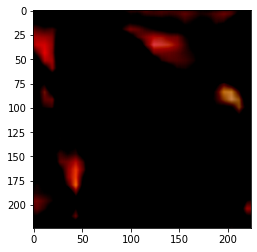

In [ ]:
img, label = CIFAR_val[30] 
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Hparams and Loaders

In [ ]:
batch_size=256
val_batch_size=256
num_epochs=130
learning_rate=2*1e-3

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader=torch.utils.data.DataLoader(tinyCIFAR,batch_size=batch_size,shuffle=True, num_workers=4)
train_acc_loader=torch.utils.data.DataLoader(tinyCIFAR,batch_size=256,shuffle=False,num_workers=4)
val_loader = torch.utils.data.DataLoader(CIFAR_val, batch_size=val_batch_size, shuffle=False,num_workers=4)

# Model

In [ ]:
resnet18 =models.resnet18(pretrained=False, progress=True)
resnet18=resnet18.to(dev)
loss_func= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=130)

## Training

In [ ]:
max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

In [ ]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= resnet18(imgs)
    loss=loss_func(out,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = resnet18(imgs) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    
    val_acc.append(correct_val/total_val)

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=resnet18(train_acc_imgs)
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    if correct_val/total_val > max_validation:
      max_validation=correct_val/total_val
      max_epoch=i
      #torch.save(resnet18,'/content/drive/MyDrive/ELL793/Assn3/tiny_with_aug/model5.pt' )
    
    train_acc.append(correct_train_acc/total_train_acc)
  epochs.append(i)


  if i%1==0:
    print("Epoch: %d, Loss: %f" % (i, float(loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)
  
  scheduler.step()

print(max_validation)

Epoch: 0, Loss: 4.141980
Train Accuracy:  0.0976
Validation Accuracy:  0.0952
Epoch: 1, Loss: 2.604615
Train Accuracy:  0.196
Validation Accuracy:  0.197
Epoch: 2, Loss: 2.082600
Train Accuracy:  0.2282
Validation Accuracy:  0.2416
Epoch: 3, Loss: 2.058468
Train Accuracy:  0.2352
Validation Accuracy:  0.2593
Epoch: 4, Loss: 1.979562
Train Accuracy:  0.263
Validation Accuracy:  0.2993
Epoch: 5, Loss: 1.939417
Train Accuracy:  0.2962
Validation Accuracy:  0.3444
Epoch: 6, Loss: 1.936843
Train Accuracy:  0.2952
Validation Accuracy:  0.3391
Epoch: 7, Loss: 1.801767
Train Accuracy:  0.312
Validation Accuracy:  0.3509
Epoch: 8, Loss: 1.805172
Train Accuracy:  0.308
Validation Accuracy:  0.3535
Epoch: 9, Loss: 1.756196
Train Accuracy:  0.33
Validation Accuracy:  0.3805
Epoch: 10, Loss: 1.819119
Train Accuracy:  0.331
Validation Accuracy:  0.3909
Epoch: 11, Loss: 1.682024
Train Accuracy:  0.3226
Validation Accuracy:  0.3764
Epoch: 12, Loss: 1.734309
Train Accuracy:  0.3416
Validation Accuracy:

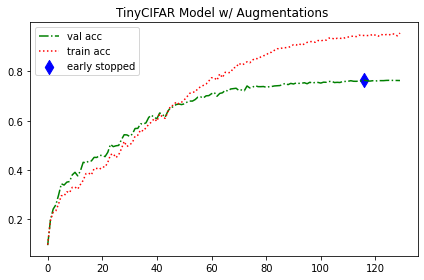

In [ ]:
plt.plot(epochs, val_acc, label="val acc", color="green", linestyle='-.')
plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
plt.scatter([max_epoch], [max_validation],color="blue", marker="d", label="early stopped", s=100 )
plt.title("TinyCIFAR Model w/ Augmentations ")
plt.legend()
plt.tight_layout()
plt.savefig('tinyAug5[224].png',dpi=600)
plt.show()
#torch.save(val_acc, '/content/drive/MyDrive/ELL793/Assn3/tiny_with_aug/val_acc_tinyaug5.pt')
#torch.save(train_acc, '/content/drive/MyDrive/ELL793/Assn3/tiny_with_aug/train_acc_tinyaug5.pt')

In [ ]:
print(max_validation)
from google.colab import files
files.download('tinyAug5[224].png') 


0.7644


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>